## MIDS - Spotify Base Data Review

In [3]:
# base modules
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn.model_selection
import sklearn.metrics

# custom modules
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from pathlib import Path
from bs4 import BeautifulSoup
from musixmatch import Musixmatch
#from lyricsgenius import Genius
import requests
import seaborn as sns
import json
import xgboost as xgb
import os
import re

In [24]:
musixmatch = Musixmatch(musix_cid)
musixmatch.matcher_track_get('Sauce', 'Max Chapman')

{'message': {'body': {'track': {'album_id': 35540922,
    'album_name': 'Fantasy - Single',
    'artist_id': 41860734,
    'artist_name': 'Max Chapman feat. Late Replies',
    'commontrack_id': 103046917,
    'explicit': 0,
    'has_lyrics': 0,
    'has_richsync': 0,
    'has_subtitles': 0,
    'instrumental': 0,
    'num_favourite': 0,
    'primary_genres': {'music_genre_list': []},
    'restricted': 0,
    'track_edit_url': 'https://www.musixmatch.com/lyrics/Max-Chapman-Late-Replies-26/Sauce/edit?utm_source=application&utm_campaign=api&utm_medium=UC+Berkeley%3A1409622602394',
    'track_id': 187785107,
    'track_name': 'Sauce',
    'track_name_translation_list': [],
    'track_rating': 1,
    'track_share_url': 'https://www.musixmatch.com/lyrics/Max-Chapman-Late-Replies-26/Sauce?utm_source=application&utm_campaign=api&utm_medium=UC+Berkeley%3A1409622602394',
    'updated_time': '2019-11-15T08:49:07Z'}},
  'header': {'cached': 0,
   'confidence': 950,
   'execute_time': 0.06740498542

In [25]:
musixmatch.track_lyrics_get(103046917)

{'message': {'body': {'lyrics': {'explicit': 0,
    'lyrics_body': 'Tuhanku ampunkanlah\nSegala dosaku\nTuhanku maafkanlah\nKejahilan hambaMu\nKu sering melanggar larangan Mu\nDalam sedar ataupun tidak\nKu sering meninggalkan suruhanMu\nWalau sedar aku milikMu\n\nTuhanku ampunkan lahsegalala dosaku\nTuhanku maafkan lah kejahilan hamba Mu\nBilakah diri ini kan kembali\nKepada nikmat sebenar\n...\n\n******* This Lyrics is NOT for Commercial use *******\n(1409622602394)',
    'lyrics_copyright': 'Lyrics powered by www.musixmatch.com. This Lyrics is NOT for Commercial use and only 30% of the lyrics are returned.',
    'lyrics_id': 15488683,
    'pixel_tracking_url': 'https://tracking.musixmatch.com/t1.0/m_img/e_1/sn_0/l_15488683/su_0/rs_0/tr_3vUCABseAPr93O9adBucoOPyjeaNSY2cx2nYk_z3Cq-sRugPmh_Ujnh4rqGMnq1-2jb51Via5UkecYa9_odOwS_oG-Wwv1gqLePCXuN1TQt_n8xx_fM8Idj1atrfXcl7emTAs7k2pxv1lSe_JBW6pSJymvZOGAZQ0wrhLucTkpwO3DRW-8ro11LZStaC2N7HcKXeAoJTZmExEl7KqGoqxGRBrJFjYdrORKct7Dcj8LiVaY2qQ58eAv9qK9sA

In [15]:
#Spotify creds
cid = Path('_keys/cid.txt').read_text()
secret = Path('_keys/secret.txt').read_text()

#Genius creds
genius_cid = Path('_keys/genius_cid.txt').read_text()
genius_secret = Path('_keys/genius_secret.txt').read_text()

#Musixmatch creds
musix_cid = Path('_keys/musix_id.txt').read_text()

In [16]:
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

#genius = Genius(genius_cid)

In [17]:
genres = pd.read_csv('_data/genres_v2.csv')
playlist = pd.read_csv('_data/playlists.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
genres['genre'].value_counts()

Underground Rap    5875
Dark Trap          4578
Hiphop             3028
trance             2999
trap               2987
techhouse          2975
dnb                2966
psytrance          2961
techno             2956
hardstyle          2936
RnB                2099
Trap Metal         1956
Rap                1848
Emo                1680
Pop                 461
Name: genre, dtype: int64

In [ ]:
## subset to just electro-related count
use_genres = ['trance', 'techhouse', 'dnb', 'techno']

electro_songs = genres[genres.genre.isin(use_genres)]

In [ ]:
## get song popularity
def popularity(df):
    empty = []
    for i in df['uri']:
            series_track = pd.Series(sp.track(i))
            empty.append(series_track)
    df2 = pd.DataFrame(empty)
    return df2

electro_popularity = popularity(electro_songs)

ReadTimeout: ignored

In [ ]:
electro_popularity

NameError: ignored

In [ ]:
electro_popularity.to_csv('elctro_pull.csv')

In [18]:
electro_popularity = pd.read_csv('elctro_pull.csv')

Plot distribution of popularity score.

[Text(0.5, 1.0, 'Total Popularity Distribution')]

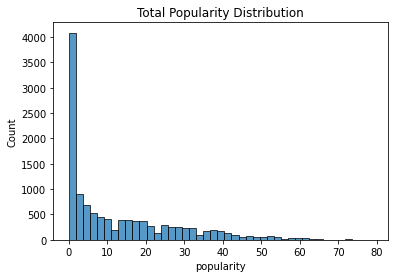

In [ ]:
sns.histplot(data = electro_popularity
            ,x = 'popularity'
            ).set(title='Total Popularity Distribution')

[Text(0.5, 1.0, 'Non-0 Popularity Distribution')]

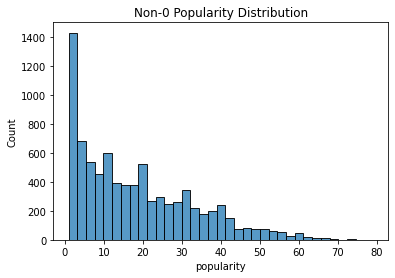

In [ ]:
sns.histplot(data = electro_popularity.loc[electro_popularity['popularity'] > 0]
            ,x = 'popularity'
            ).set(title='Non-0 Popularity Distribution')

In [19]:
## remove any songs with no popularity - assuming these are too small to be considered
electro_short = electro_popularity.loc[electro_popularity['popularity'] > 0]

In [20]:
# parse artist names from JSON response
def parse_artist(df):
  empty = []
  for i in df['artists']:
    line_artists = []
    try:
      artist_lists = json.loads(i.replace("\'", "\""))
    except:
      #print(i)
      artists_lists = []
    for j in artist_lists:
      line_artists.append(j['name'])
    empty.append(line_artists)
  return empty


electro_short['artist_names'] = parse_artist(electro_short)
electro_short['first_artist'] = electro_short.apply(lambda row: row.artist_names[0], axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [21]:
out = pd.DataFrame(electro_short.first_artist.value_counts())
out

,first_artist
Armin van Buuren,84
Aly & Fila,73
Above & Beyond,50
Walker & Royce,41
Cloonee,40
...,...
Gareth Wild,1
Sinfol,1
Underworld,1
Maelstrom,1


[Text(0.5, 1.0, 'Arist Song Count')]

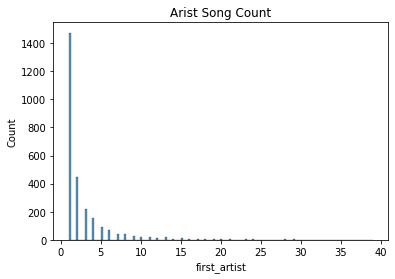

In [ ]:
sns.histplot(data = out.loc[out['first_artist'] < 40]
            ,x = 'first_artist'
            ).set(title='Arist Song Count')

In [22]:
use_cols = ['href', 'popularity', 'name', 'first_artist']
electro_short_join = electro_short[use_cols]

In [23]:
electro_short_join

,href,popularity,name,first_artist
0,https://api.spotify.com/v1/tracks/5LzAV6KfjN8V...,30,Sauce,Max Chapman
1,https://api.spotify.com/v1/tracks/6nxvhvk9etkP...,24,Music Please,Detlef
2,https://api.spotify.com/v1/tracks/3TsCb6ueD678...,22,Ooh Tune - Danny Howard Remix,Shadow Child
3,https://api.spotify.com/v1/tracks/6Y0Fy2buEis7...,2,Dust (feat. Badbox),Robin M
4,https://api.spotify.com/v1/tracks/4EJI2XGViSQp...,50,Pretty Baby,Redondo
...,...,...,...,...
11889,https://api.spotify.com/v1/tracks/7glEDEzVhstE...,3,Gold,Ownglow
11890,https://api.spotify.com/v1/tracks/2m9oMX34OOMK...,35,Demons,T & Sugah
11891,https://api.spotify.com/v1/tracks/3aezqOl72dNj...,2,Bitter Professional,Sinic
11894,https://api.spotify.com/v1/tracks/1C7gZX83AIi5...,8,Don't Hold Back,Bachelors of Science


In [12]:
genres_joined = pd.merge(genres.drop('genre', axis=1).drop_duplicates(), 
                         electro_short_join.drop_duplicates(),
                         left_on='track_href', right_on='href', how='left')
genres_joined_electro = genres_joined.loc[~pd.isna(genres_joined.first_artist)]

In [13]:
genres_joined_electro.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'time_signature', 'song_name', 'Unnamed: 0', 'title', 'href',
       'popularity', 'name', 'first_artist'],
      dtype='object')

In [14]:
agg_cols = {'danceability':'mean',
            'energy':'mean',
            'key': 'mean',
            'loudness':'mean',
            #'mode':'mean',
            'speechiness':'mean',
            'acousticness':'mean',
            'instrumentalness':'mean',
            'liveness': 'mean',
            'valence':'mean',
            'tempo':'mean',
            'popularity': 'mean'}

electro_agg_metrics = genres_joined_electro.groupby('first_artist').agg(agg_cols)

In [15]:
electro_agg_metrics

,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,popularity
first_artist,,,,,,,,,,,
1991,0.451444,0.878556,4.944444,-3.23400,0.046628,0.012991,0.340653,0.235772,0.351944,174.024111,32.333333
1st in Line,0.194000,0.999000,10.000000,-4.74900,0.097300,0.000621,0.915000,0.344000,0.257000,137.979000,13.000000
2000 And One,0.787750,0.850500,4.750000,-8.60525,0.045800,0.000097,0.862500,0.209750,0.066175,129.759250,8.250000
2pole,0.740000,0.812375,5.000000,-7.91075,0.088175,0.013872,0.808125,0.111025,0.111687,130.130750,13.125000
4 Strings,0.485550,0.869150,5.050000,-7.64460,0.066450,0.004663,0.317804,0.273420,0.098530,135.702300,8.650000
...,...,...,...,...,...,...,...,...,...,...,...
tEho & Tran,0.762000,0.444000,4.000000,-13.91500,0.049700,0.013200,0.877000,0.059000,0.366000,121.994000,2.000000
tranzLift,0.509000,0.926750,6.000000,-7.62425,0.071125,0.000491,0.882000,0.340000,0.186750,138.497250,4.750000
twoloud,0.735000,0.853000,0.000000,-6.34200,0.074800,0.000719,0.393000,0.158000,0.489000,124.976000,6.000000


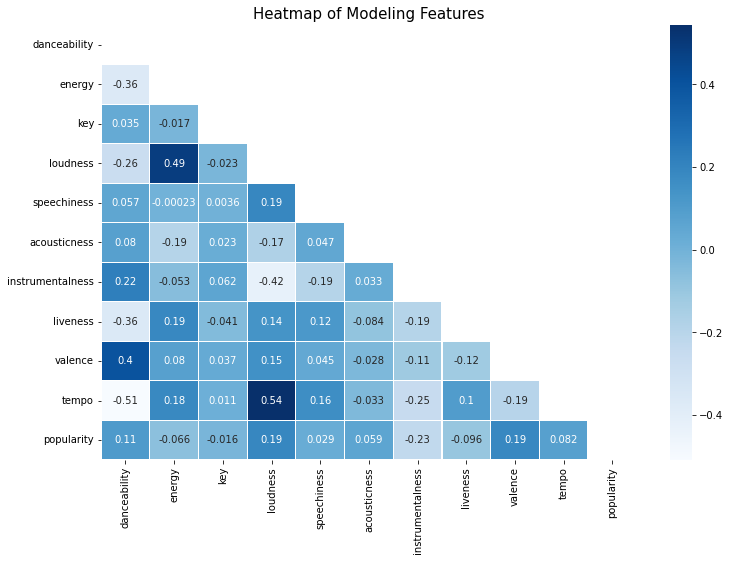

In [16]:
corr = electro_agg_metrics.corr()

fig, ax = plt.subplots(figsize = (12,8))

sns.heatmap(corr, mask = np.triu(np.ones_like(corr, dtype = bool)), cmap = 'Blues', annot = True, 
           linewidths = .2)

plt.title('Heatmap of Modeling Features', fontsize = 15)
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(electro_agg_metrics.drop('popularity', axis = 1), 
                                                                            electro_agg_metrics.popularity,
                                                    random_state = 1111,
                                                    test_size = 0.3)

In [ ]:
## Create dictionary to track model results
results = {}

def add_results(y_pred, model_name):
    ## Add results of test data to tracker, with user input to ensure data is overwritten on purpose
    if model_name in results.keys():
        userIn = input("Model already in dictionary. Add? ").lower()
        if userIn == 'yes':
            results[model_name] = round(sklearn.metrics.mean_squared_error(y_test, y_pred), 2)**.5
        else:
            pass
    else:
        results[model_name] = round(sklearn.metrics.mean_squared_error(y_test, y_pred), 2)**.5
    print(results)

In [ ]:
XGB_MVP = xgb.XGBRegressor(objective='reg:squarederror',
                                seed=100).fit(X_train, y_train)
add_results(XGB_MVP.predict(X_test), "XGB_Base")

{'XGB_Base': 11.956169955299229}


## pull from MusixMatch

In [ ]:
genres_joined_electro.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,analysis_url,duration_ms,time_signature,song_name,Unnamed: 0,title,href,popularity,name,first_artist
3319,0.413,0.924,9,-3.767,0,0.0418,0.00364,0.784000,0.1080,0.0708,...,https://api.spotify.com/v1/audio-analysis/3cqW...,261401,4,Never Be Alone,NaN,NaN,https://api.spotify.com/v1/tracks/3cqWZkSohwFW...,28.0,Never Be Alone,T & Sugah
3335,0.537,0.906,8,-1.167,0,0.0651,0.13300,0.018700,0.3190,0.5040,...,https://api.spotify.com/v1/audio-analysis/507U...,215172,4,Desire (with Dimension),NaN,NaN,https://api.spotify.com/v1/tracks/507UUx311ghf...,62.0,Desire (with Dimension),Sub Focus
16006,0.630,0.928,9,-2.787,0,0.0331,0.19900,0.124000,0.1480,0.4650,...,https://api.spotify.com/v1/audio-analysis/0azC...,222160,4,This Is What You Came For (feat. Rihanna),NaN,NaN,https://api.spotify.com/v1/tracks/0azC730Exh71...,79.0,This Is What You Came For (feat. Rihanna),Calvin Harris
16060,0.572,0.802,5,-5.286,0,0.0412,0.01250,0.000101,0.1350,0.5550,...,https://api.spotify.com/v1/audio-analysis/3oeB...,193103,4,Out of My Head,NaN,NaN,https://api.spotify.com/v1/tracks/3oeBaOmuWeNP...,39.0,Out of My Head,Prefekt
16063,0.520,0.789,0,-7.717,1,0.0433,0.00491,0.000013,0.0816,0.4160,...,https://api.spotify.com/v1/audio-analysis/697M...,216347,4,I Miss You,NaN,NaN,https://api.spotify.com/v1/tracks/697MjF1454XK...,24.0,I Miss You,Jeff Slaugh


In [ ]:
def parse_lyrics(df):
  empty = []
  for row, artist in df.first_artist.iteritems():
    song_title = df['name'].loc[row]
    lyrics_return = ''
    try:
      lyrics_return =  genius.search_song(song_title, artist).lyrics
    except:
      lyrics_return = ''
    empty.append(lyrics_return)
  return empty

parse_artist(genres_joined_electro.head())

Searching for "Never Be Alone" by T & Sugah...
Specified song does not contain lyrics. Rejecting.
Searching for "Desire (with Dimension)" by Sub Focus...
Done.
Searching for "This Is What You Came For (feat. Rihanna)" by Calvin Harris...
Done.
Searching for "Out of My Head" by Prefekt...
Done.
Searching for "I Miss You" by Jeff Slaugh...
Done.


[[], [], [], [], []]

In [ ]:
genius.remove_section_headers = True # Remove section headers (e.g. [Chorus]) from lyrics when searching
genius.skip_non_songs = False # Include hits thought to be non-songs (e.g. track lists)

song = genius.search_song('I Miss You', 'Jeff Slaugh')

song.lyrics

Searching for "I Miss You" by Jeff Slaugh...
Done.


"Rap on Rappers Lyrics\nSo I walked into a store with a couple BUCKs from the BANK,\nSaw a pack of M&Ms asked how much? 50 CENTs? Thanks,\nGrabbed a box of Ike & MIKEs JONES to wash it down,\nA bag of ICE CUBEs cuz I like my drinks COLD now,\nSaw a LIL REESE man those get me goin' MEEK,\nBut I was TOO SHORT of change so it looked MEMPHIS BLEEK,\nJust then a SCHOOLBOY walks in ABSOLutely cool 2 CHAINZ on,\nAsks for a 2 PACK of NOTORIOUSly BIG candies I'm like GAME on,\nI creep in like a TIGER hiding behind WALL-A,\nTry looking COMMON not to PUSH him Away,\nHe SIGHs HIGH like a PRINCE, FRENCH hat from MONTANA,\nThis BIG BOI must be an OUTCAST cuz he looks like a DUMBFOUNDED banana,\nSo now I'm stepping up to him and just BUST A RHYME,\nSaying I'm a DOCTOR slash SOULJA BOY who has no time,\nAnd that I'd appreciate some change so I can be free like a BIRD MAN,\nThis KID KID thinks I'm LUDICROUS gives mE 40 cents I'm like word man,\nThat scene was a FIASCO but I feel FABULOUS,\nWalk into th